# Homomorphic Encryption - Ordinary Least Square

Martin Kersner, <m.kersner@gmail.com>

2018/02/26

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [0]:
# m number of data points
# n number of features
m = 32
n = 1

In [0]:
def generate_1d_dataset(m, n, factor=2.0):
  X = np.matrix(np.expand_dims(np.arange(m), 1))
  y = X + np.random.random((m, n)) * factor

  return train_test_split(X, y, test_size=0.5, random_state=42)

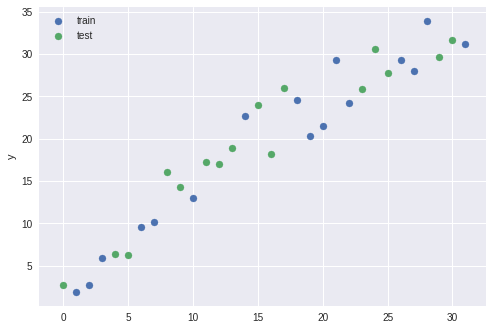

In [4]:
X_train, X_test, y_train, y_test = generate_1d_dataset(m, n, factor=10.0)
plt.scatter(X_train.T.tolist()[0], y_train.T.tolist()[0], label="train")
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()

In [0]:
class HomomorphicEncoder(object):
  def __init__(self, m, n):
    self.m = m
    self.n = n
    self.U = self._orthogonal_matrix(self.m, self.m)
    
  def _orthogonal_matrix(self, m, n):
    q, _ = np.linalg.qr(np.random.random(size=(m, n)))
    assert q.shape == (m, n)
    return q
  
  def _encrypt(self, v):
    v̂ = self.U @ v
    assert v.shape == v̂.shape
    return v̂
  
  def _decrypt(self, v̂): 
    v = self.U.T @ v̂
    assert v.shape == v̂.shape
    return v
  
  def encrypt(self, X, y):
    return self._encrypt(X), self._encrypt(y)
  
  def test(self):
    value = np.random.random((self.m, self.n))
    value_enc = self._encrypt(value)
    value_dec = self._decrypt(value_enc)
    assert np.isclose(np.sum(value - value_dec), 0.0)

In [0]:
hme = HomomorphicEncoder(16, 1)
hme.test()

X̃_train, ỹ_train = hme.encrypt(X_train, y_train)
X̃_test, ỹ_test = hme.encrypt(X_test, y_test)

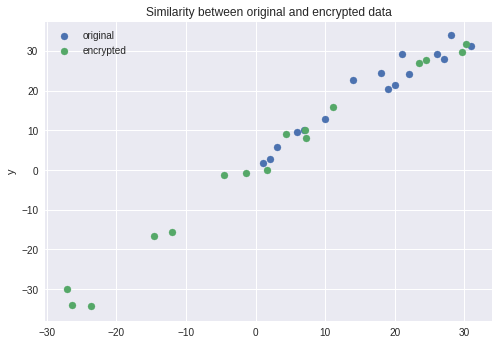

In [7]:
plt.scatter(X_train.T.tolist()[0], y_train.T.tolist()[0], label="original")
plt.scatter(X̃_train.T.tolist()[0], ỹ_train.T.tolist()[0], label="encrypted")
plt.title("Similarity between original and encrypted data")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()

In [0]:
class OrdinaryLeastSquares(object):
  def __init__(self):
    self.β̂ = None

  def fit(self, X, y):
    XtX = X.T @ X

    # matrix must be non-singular
    assert np.linalg.det(XtX) != 0.0

    self.β̂ = XtX.I @ X.T @ y

  def predict(self, X):
    return X @ self.β̂

## Training and prediction on original (unencrypted) data

In [9]:
ols_orig = OrdinaryLeastSquares()
ols_orig.fit(X_train, y_train)
y_pred_orig = ols_orig.predict(X_test)
print(f"R-squared: {r2_score(y_test, y_pred_orig)}")

R-squared: 0.8088158117589734


## Training and prediction on encrypted data

In [10]:
ols_homo = OrdinaryLeastSquares()
ols_homo.fit(X̃_train, ỹ_train)
y_pred_homo = hme._decrypt(ols_homo.predict(X̃_test))
print(f"R-squared: {r2_score(y_test, y_pred_homo)}")

R-squared: 0.8088158117589734


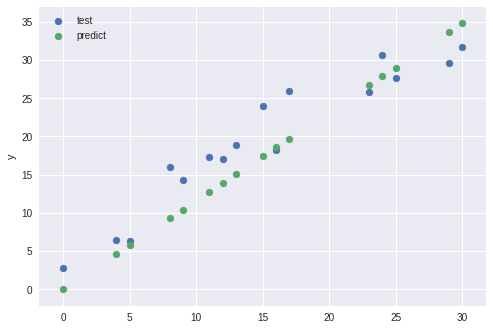

In [11]:
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.scatter(X_test.T.tolist()[0], y_pred_homo.T.tolist()[0], label="predict")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()